Step 1: Installing and importing required packages to import data from telegram messenger. 

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from telethon import TelegramClient

In [4]:
import pandas as pd
import numpy as np

In [5]:
import re

In [6]:
from collections import Counter

In [7]:
import time

Step 2: Authorising account in telegram to get an access to the data file. 

In [8]:
api_id = -----
api_hash = '--------------'
phone_number = '--------'

In [9]:
client = TelegramClient('session_id', api_id=api_id, api_hash=api_hash)

In [10]:
assert client.connect()

In [19]:
if not client.is_user_authorized():
    client.send_code_request(phone_number)
    me = client.sign_in(phone_number, input('Enter code: '))
    print(me.stringify())

chat_id = ------

Step 3: Loading data by batches of 10000 messages for safety. The code automatically filters every batch from unnecessary information. 

In [20]:

def load_batch(chat_id, batch_size, last_batch_message_id):
    return client.get_message_history(chat_id, limit=batch_size, offset_id=last_batch_message_id)

def process_batch(batch):
    processed_messages = []
    for current_message in batch:
        try:
            current_message.media
            processed_messages.append(current_message)
        except:
            pass
    return processed_messages

Step 4: Setting up a maximum amount of messages and summarizing the number of messages. 

In [21]:
max_messages = 100000000

work_messages = []
time_elapsed = 0
batch_size = 10000
last_batch_message_id = -1

try:    
    while(len(work_messages) < max_messages):
        try:
            time_batch_start = time.time()
            loaded_messages = load_batch(
                chat_id, batch_size, last_batch_message_id)
            processed_messages = process_batch(loaded_messages)
            if len(processed_messages)==0:
                break
            work_messages.extend(processed_messages)
            last_batch_message_id = processed_messages[-1].id
            batch_duration = time.time() - time_batch_start
            time_elapsed += batch_duration
            print('Batch with {0} messages loaded for {1} seconds'.format(
                len(processed_messages), int(batch_duration)
            ))
            print('History loaded until {}'.format(work_messages[-1].date))
            print('Overall loaded {0} messages for {1} minutes\n'.format(
                len(work_messages), int(time_elapsed / 60)
            ))
        except RuntimeError:
            print('RUNTIME ERROR - try load batch again')
        
except KeyboardInterrupt:
    pass

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/telethon/telegram_client.py:1091: UserWarning: get_message_history is deprecated, use get_messages instead
  'get_message_history is deprecated, use get_messages instead'


Batch with 9963 messages loaded for 130 seconds
History loaded until 2017-12-13 03:31:53
Overall loaded 9963 messages for 2 minutes

Batch with 7941 messages loaded for 102 seconds
History loaded until 2017-09-21 07:15:28
Overall loaded 17904 messages for 3 minutes



Step 5: Filtering data and creating my own data frame and dividing it by username. 

In [22]:
corpus = pd.DataFrame(data = {
    'text': [mes.message for mes in work_messages],
    'is_media': [not mes.media == None for mes in work_messages],
    'is_bot': [mes.sender.bot for mes in work_messages],
    'writer_id': [mes.from_id for mes in work_messages],
    'username': [mes.sender.username for mes in work_messages],
    'first_name': [mes.sender.first_name for mes in work_messages],
    'last_name': [mes.sender.last_name for mes in work_messages],
    'mes_date': [mes.date for mes in work_messages],
    
})
corpus = corpus[~corpus.is_bot]
corpus = corpus[['mes_date', 'text', 'is_media', 'username', 'writer_id', 'first_name', 'last_name']]
corpus.text = corpus.text.fillna('').astype(str)

def remove_links_and_quotes(text):
    return ' '.join([word for word in text.split() if 'http' not in word and '@' not in word])
corpus.text = corpus.text.apply(lambda x: remove_links_and_quotes(x))

corpus = corpus[corpus.text.apply(lambda x: len(x) > 0)]
corpus.text = corpus.text.apply(lambda x: ' '.join(re.split('\W+', x.lower())))
corpus.sort_values('mes_date', inplace=True, ascending=True)

corpus.fillna('', inplace=True)
corpus['chatname'] = corpus['last_name'] + '_' + corpus['first_name'] + '(' + corpus['username'] + ')'

corpus.to_csv('joshua_chat.csv', index=None)

corpus.head(10)

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
17903,2017-09-21 07:15:28,hey,False,,362218386,Aisulu,Omar,Omar_Aisulu()
17902,2017-09-21 07:15:42,hey,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17901,2017-09-21 07:15:44,cool,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17900,2017-09-21 07:16:22,good night,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17899,2017-09-21 07:16:25,thanks for talking,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17898,2017-09-21 07:16:28,you re great,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17897,2017-09-21 07:19:10,good night thank you for sharing,False,,362218386,Aisulu,Omar,Omar_Aisulu()
17895,2017-09-21 15:33:34,someone over 21 from mexico may have to wait 2...,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
17894,2017-09-21 16:17:05,sad,False,,362218386,Aisulu,Omar,Omar_Aisulu()
17893,2017-09-21 20:24:30,does my fb appear to be active,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)


In [24]:
corpus = pd.read_csv('joshua_chat.csv')
corpus.fillna('', inplace=True)
corpus.mes_date = pd.to_datetime(corpus.mes_date)
corpus.head()

,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-09-21 07:15:28,hey,False,,362218386,Aisulu,Omar,Omar_Aisulu()
1,2017-09-21 07:15:42,hey,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
2,2017-09-21 07:15:44,cool,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
3,2017-09-21 07:16:22,good night,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
4,2017-09-21 07:16:25,thanks for talking,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)


In [25]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def tokenize_me(file_text):
    #firstly let's apply nltk tokenization
    tokens = nltk.word_tokenize(file_text)

    #deleting stop_words
    stop_words = stopwords.words('english')
    stop_words.extend(['this', 'like', 'so', 'and', 'hey', 'for', 'hi', 'that', 'on', 'in'])
    tokens = [i for i in tokens if ( i not in stop_words )]
    
    #cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]

    return ' '.join(tokens)

corpus.text = corpus.text.apply(lambda x: tokenize_me(x))

corpus.to_csv('joshua_chat_tokens.csv', index=None)
corpus.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aisuluomar/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aisuluomar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,mes_date,text,is_media,username,writer_id,first_name,last_name,chatname
0,2017-09-21 07:15:28,,False,,362218386,Aisulu,Omar,Omar_Aisulu()
1,2017-09-21 07:15:42,,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
2,2017-09-21 07:15:44,cool,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
3,2017-09-21 07:16:22,good night,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
4,2017-09-21 07:16:25,thanks talking,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
5,2017-09-21 07:16:28,great,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
6,2017-09-21 07:19:10,good night thank sharing,False,,362218386,Aisulu,Omar,Omar_Aisulu()
7,2017-09-21 15:33:34,someone 21 mexico may wait 21 years get us,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)
8,2017-09-21 16:17:05,sad,False,,362218386,Aisulu,Omar,Omar_Aisulu()
9,2017-09-21 20:24:30,fb appear active,False,Joshuuu,309823963,Joshua,,_Joshua(Joshuuu)


Step 6: Identifying the number of messages by username.

In [26]:
corpus.groupby('chatname')['text'].count().sort_values(ascending=False).head(15)


chatname
_Joshua(Joshuuu)    9396
Omar_Aisulu()       6306
Name: text, dtype: int64

In [27]:
corpus.groupby('chatname')['is_media'].sum().sort_values(ascending=False).astype(int).head(15)

chatname
_Joshua(Joshuuu)    18
Omar_Aisulu()        7
Name: is_media, dtype: int64

Step 7: Creating the graph of activity of our chat throughout the time.

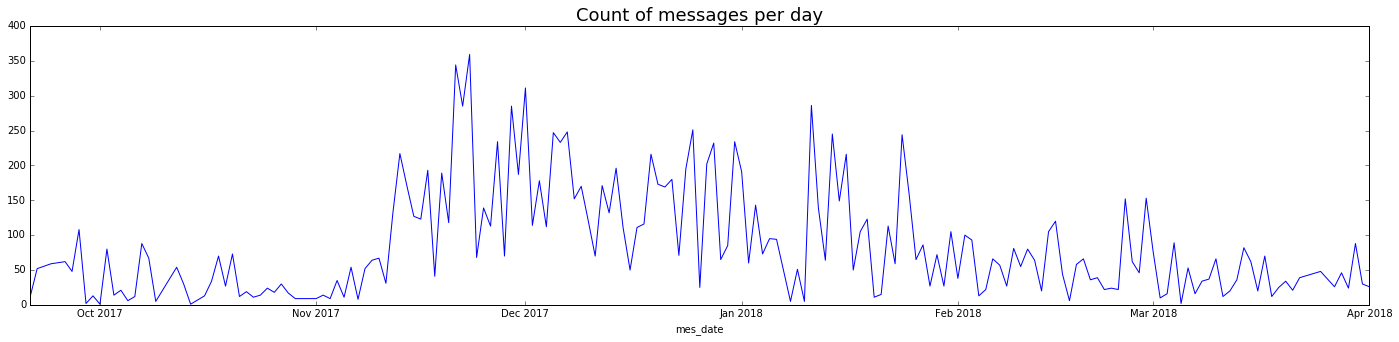

In [28]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.date).count().mes_date.plot(figsize=(24,5))
plt.title('Count of messages per day', fontsize=18)
plt.savefig('joshua_bydays.png')


Step 8: Creating the graph of activity of number of messages based on time of the day. 

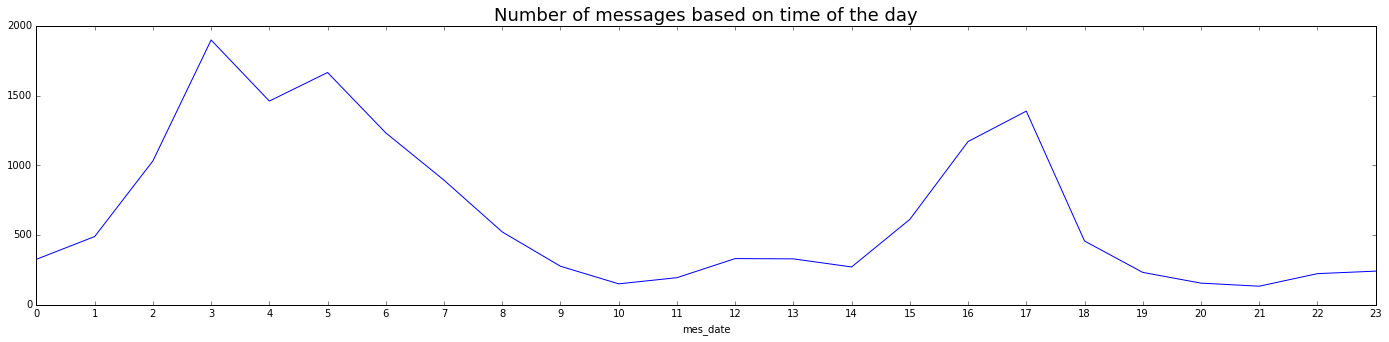

In [29]:
import matplotlib.pylab as plt
%matplotlib inline

corpus.groupby(corpus.mes_date.dt.hour).count().mes_date.plot(figsize=(24,5))
plt.title('Number of messages based on time of the day', fontsize=18)
plt.xticks(range(24))
plt.show()

In [1]:
import sys
#!{sys.executable} -m pip install pymorphy2

Step 9: Filtering data by qulifiers and intensifiers. 

In [32]:
import pymorphy2

users_text = corpus[corpus.chatname.map((corpus.groupby('chatname')['text'].count() > 50))]

users_text = users_text.groupby('chatname').agg(lambda x: ' '.join(x))['text']

morph = pymorphy2.MorphAnalyzer()


In [33]:
# Apro
def normalise_string(input_str):
    bad_words = {'so','like','very','more',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(parsed.normal_form)
    return ' '.join(norm_words_list)

%time users_text_norm = users_text.apply(lambda x: normalise_string(x))
users_text_norm.head()

CPU times: user 2.44 s, sys: 28.2 ms, total: 2.47 s
Wall time: 2.5 s


chatname
Omar_Aisulu()       good night thank sharing sad active anymore no...
_Joshua(Joshuuu)    cool good night thanks talking great someone m...
Name: text, dtype: object

In [34]:
def filter_string(input_str):
    bad_words = {'so','like','very','more',}
    norm_words_list = []
    for word in input_str.split():
        if not word.isdigit() and word not in bad_words:
            parsed = morph.parse(word)[0]
            if parsed.tag.POS not in {'NUMR', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}:
                norm_words_list.append(word)
    return ' '.join(norm_words_list)

%time users_text_filter = users_text.apply(lambda x: filter_string(x))
users_text_filter.head()

CPU times: user 2.44 s, sys: 27.9 ms, total: 2.47 s
Wall time: 2.5 s


chatname
Omar_Aisulu()       good night thank sharing sad active anymore no...
_Joshua(Joshuuu)    cool good night thanks talking great someone m...
Name: text, dtype: object

Step 10: Removing meaningless and unnecessary words. 

In [37]:
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time

def get_words_by_threshold_report(text_series, min_df=0.02, max_df=0.75):
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)

    counts = vectorizer.fit_transform(text_series)
    corpus_id2word = {value: key for key, value in vectorizer.vocabulary_.items()}

    print('Words in the library: {}\n'.format(counts.shape[1]))
    print('Words that are not applicable to the threshold: ', Counter(' '.join(text_series.values).split()).most_common(20), '\n')

    print('Words with the higher threshold:', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[-40:][::-1]])
    print()
    print('Words with the lower threshold: ', [corpus_id2word[elem] for elem in np.argsort(np.array(counts.sum(axis=0)).ravel())[:20]])
    return counts, vectorizer, corpus_id2word

def get_lda_model(counts, corpus_id2word, num_topics=10, alpha_value=0.1, var_iter=50, passes=50):
    gensim_corpus = gensim.matutils.Scipy2Corpus(counts)
    t_start = time.time()
    lda = gensim.models.LdaModel(
        corpus=gensim_corpus,
        passes=passes,
        num_topics=num_topics,
        alpha=[alpha_value] * num_topics,
        iterations=var_iter,
        id2word=corpus_id2word,
        eval_every=0,
        random_state=42
    )
    current_score = lda.bound(gensim_corpus)
    time_ellapsed = int(time.time() - t_start)

    print('ELBO = {1:.4f}, time: {2} seconds'.format(
        alpha_value, current_score, time_ellapsed))
    
    gamma, _ = lda.inference(gensim_corpus)
    gamma = gamma / gamma.sum(1).reshape(-1, 1)
    
    return lda, gamma

def build_topic_words_report(lda, top_words_num=25, topic_names=None):
    if topic_names==None:
        topic_names = [''] * lda.num_topics
    topic_space = max(map(len, topic_names)) + 2
    
    if topic_space==2:
        for topic_index in range(lda.num_topics):
            print('{0} topic: {1}'.format(
                topic_index, ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        return
    
    for topic_index in range(lda.num_topics):
        print('{0} topic :{1: ^{2}}: {3}'.format(
            topic_index, topic_names[topic_index], topic_space,
            ', '.join(list(zip(*lda.show_topic(topic_index, topn=top_words_num)))[0])))
        

Step 11: List of words in the initial form. 

In [38]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(users_text_norm, min_df=0.02, max_df=0.75)

Words in the library: 4753

Words that are not applicable to the threshold:  [('good', 948), ('really', 546), ('think', 537), ('going', 468), ('yes', 449), ('feel', 430), ('know', 425), ('time', 423), ('want', 412), ('also', 400), ('love', 379), ('work', 353), ('sleep', 319), ('people', 310), ('night', 304), ('talk', 301), ('day', 283), ('ok', 280), ('okay', 269), ('get', 264)] 

Words with the higher threshold: ['anyway', 'na', 'tho', 'within', 'sort', 'josé', 'sometime', 'across', 'heading', 'colleague', 'gon', 'yep', 'beyond', 'necessary', 'heheh', 'college', 'given', 'wan', 'narrative', 'hearing', 'clothing', 'coworking', 'progress', 'limited', 'ttyl', 'system', 'side', 'ya', 'hello', 'despite', 'political', 'context', 'incredibly', 'directly', 'unless', 'pleasure', 'state', 'journal', 'ciao', 'issues']

Words with the lower threshold:  ['100th', 'noisy', 'nonetheless', 'nonviolent', 'noooo', 'northern', 'norwegian', 'nose', 'nostalgia', 'note', 'notebook', 'notes', 'noteworthy', '

In [39]:
lda_norm, gamma_norm = get_lda_model(counts, corpus_id2word, num_topics=10)


ELBO = -75445.1959, time: 1 seconds


In [40]:
build_topic_words_report(lda_norm, top_words_num=20)

0 topic: anyway, na, across, within, sort, sometime, tho, heheh, wan, hearing, narrative, directly, necessary, college, beyond, limited, yep, context, josé, given
1 topic: anyway, na, within, sort, across, josé, yep, tho, sometime, heading, heheh, college, necessary, gon, given, progress, beyond, ttyl, colleague, pleasure
2 topic: anyway, na, sort, sometime, within, gon, college, across, beyond, josé, narrative, heading, yep, system, despite, unless, heheh, wan, necessary, americans
3 topic: anyway, na, sort, within, josé, across, sometime, heading, yep, gon, beyond, necessary, given, heheh, college, narrative, hearing, wan, progress, ttyl
4 topic: anyway, josé, na, sort, heading, within, yep, across, narrative, heheh, sometime, given, tho, unless, ya, beyond, gon, hearing, progress, journal
5 topic: anyway, na, sort, josé, across, sometime, within, tho, heading, beyond, given, heheh, college, gon, ya, yep, wan, incredibly, narrative, necessary
6 topic: tho, na, anyway, josé, within, c

Step 12: Creating more stringent threshold. 

In [42]:
day_text = corpus.groupby(corpus.mes_date.dt.date).agg(lambda x: ' '.join(x))['text']
print(day_text.shape)
day_text.head()

(183,)


mes_date
2017-09-21      cool good night thanks talking great good ni...
2017-09-22     active anymore aight thank kids profile pictu...
2017-09-24    might enjoy big sick movie pakistani guy livin...
2017-09-26     going  alright sleepy 3 pretty relaxing weeke...
2017-09-27    took bikram yoga evening holy shit destroyed u...
Name: text, dtype: object

In [43]:
morph = pymorphy2.MorphAnalyzer()
%time day_text_norm = day_text.apply(lambda x: normalise_string(x))
day_text_norm.head()

CPU times: user 2.36 s, sys: 14.2 ms, total: 2.37 s
Wall time: 2.4 s


mes_date
2017-09-21    cool good night thanks talking great good nigh...
2017-09-22    active anymore aight thank kids profile pictur...
2017-09-24    might enjoy big sick movie pakistani guy livin...
2017-09-26    going alright sleepy pretty relaxing weekend w...
2017-09-27    took bikram yoga evening holy shit destroyed u...
Name: text, dtype: object

In [44]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.75)

Words in the library: 3167

Words that are not applicable to the threshold:  [('good', 948), ('really', 546), ('think', 537), ('going', 468), ('yes', 449), ('feel', 430), ('know', 425), ('time', 423), ('want', 412), ('also', 400), ('love', 379), ('work', 353), ('sleep', 319), ('people', 310), ('night', 304), ('talk', 301), ('day', 283), ('ok', 280), ('okay', 269), ('get', 264)] 

Words with the higher threshold: ['really', 'think', 'going', 'feel', 'know', 'time', 'want', 'also', 'love', 'work', 'sleep', 'people', 'night', 'talk', 'day', 'ok', 'okay', 'get', 'go', 'oh', 'well', 'much', 'see', 'thank', 'morning', 'one', 'tomorrow', 'hope', 'home', 'would', 'way', 'right', 'later', 'got', 'us', 'sure', 'still', 'lot', 'something', 'make']

Words with the lower threshold:  ['zoom', 'packages', 'owned', 'coursera', 'outrageous', 'covers', 'oriented', 'organized', 'cows', 'craft', 'cramps', 'organism', 'ordering', 'options', 'opposition', 'opinions', 'opens', 'oops', 'olivia', 'creeping']


In [57]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)


ELBO = -124422.6126, time: 4 seconds


In [46]:
build_topic_words_report(lda_day_norm, top_words_num=15)


0 topic: night, love, time, really, think, person, want, also, going, us, would, know, space, make, photos
1 topic: jorge, josé, family, took, parents, see, love, boy, want, went, also, us, think, take, bit
2 topic: people, think, really, movie, one, oh, show, white, work, see, know, guy, later, feel, get
3 topic: know, think, want, okay, work, really, talk, feel, time, later, day, ok, home, also, tomorrow
4 topic: sleep, love, really, going, beautiful, flight, think, feel, want, oh, time, thank, look, plane, sure
5 topic: really, think, people, also, going, work, night, know, get, japanese, movie, time, sleep, want, lol
6 topic: really, people, think, feel, time, way, different, much, work, also, weight, know, sense, kind, real
7 topic: people, think, feel, love, know, really, going, talk, want, time, things, work, day, us, also
8 topic: going, think, really, time, feel, want, know, love, also, sleep, work, ok, night, go, talk
9 topic: also, going, really, love, oh, sleep, day, well, 

In [47]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-09-21,cool good night thanks talking great good nigh...,8,157,2017-09-21
2017-09-22,active anymore aight thank kids profile pictur...,8,880,2017-09-22
2017-09-24,might enjoy big sick movie pakistani guy livin...,5,1009,2017-09-24
2017-09-26,going alright sleepy pretty relaxing weekend w...,5,1040,2017-09-26
2017-09-27,took bikram yoga evening holy shit destroyed u...,8,885,2017-09-27


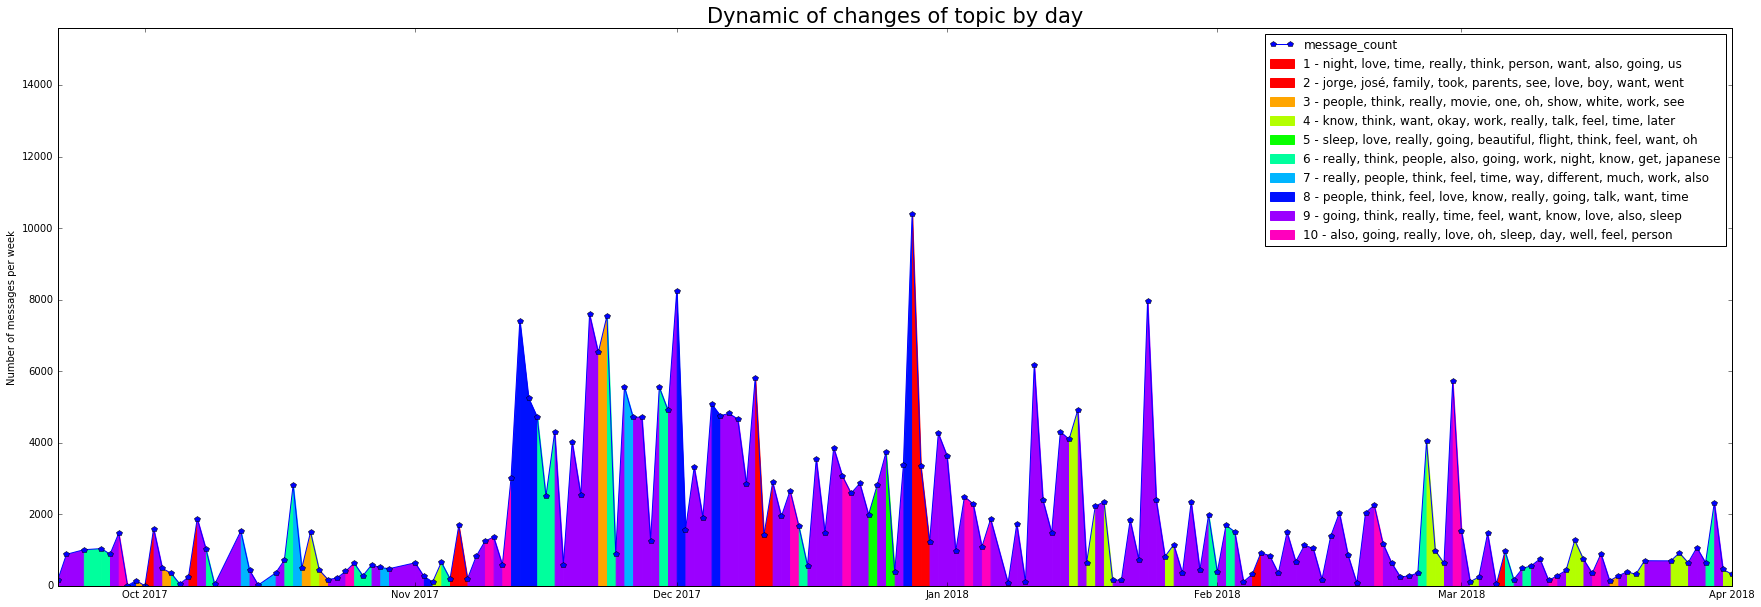

In [48]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_day_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Number of messages per week')
plt.title('Dynamic of changes of topic by day', fontsize=21)
plt.savefig('joshua_day_dynamic_norm.png')
plt.show()

In [49]:

counts, vectorizer, corpus_id2word = get_words_by_threshold_report(day_text_norm, min_df=0.01, max_df=0.45)

Words in the library: 3131

Words that are not applicable to the threshold:  [('good', 948), ('really', 546), ('think', 537), ('going', 468), ('yes', 449), ('feel', 430), ('know', 425), ('time', 423), ('want', 412), ('also', 400), ('love', 379), ('work', 353), ('sleep', 319), ('people', 310), ('night', 304), ('talk', 301), ('day', 283), ('ok', 280), ('okay', 269), ('get', 264)] 

Words with the higher threshold: ['people', 'way', 'right', 'us', 'lot', 'need', 'happy', 'friend', 'lol', 'person', 'let', 'back', 'actually', 'thanks', 'friends', 'could', 'around', 'things', 'new', 'enjoy', 'pretty', 'bit', 'try', 'take', 'nice', 'even', 'place', 'life', 'little', 'read', 'next', 'kind', 'yoga', 'come', 'fun', 'interesting', 'might', 'soon', 'maybe', 'different']

Words with the lower threshold:  ['zoom', 'coursera', 'owned', 'outrageous', 'covers', 'oriented', 'organized', 'cows', 'craft', 'cramps', 'organism', 'ordering', 'options', 'opposition', 'opinions', 'opens', 'oops', 'olivia', 'cr

In [50]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)


ELBO = -268632.8658, time: 16 seconds


In [51]:
build_topic_words_report(lda_day_norm, top_words_num=15)


0 topic: people, lol, us, lot, pretty, need, back, try, little, thanks, probably, enjoy, way, different, makes
1 topic: happy, person, hair, right, long, friends, way, space, read, call, look, makes, could, phone, beautiful
2 topic: friend, dream, people, new, person, happy, kind, interesting, year, could, actually, next, life, weird, together
3 topic: right, need, let, thanks, way, come, around, place, sorry, yoga, friends, lot, tea, could, actually
4 topic: people, way, world, food, power, ecology, need, call, energy, understand, rather, could, problem, money, car
5 topic: people, let, cool, fun, lol, dinner, yoga, nice, take, listen, right, place, video, looks, around
6 topic: journal, let, anything, around, long, feeling, rabi, weekend, place, meet, enjoy, probably, hard, write, learn
7 topic: people, way, take, right, lot, us, jorge, moment, need, bit, little, new, josé, together, told
8 topic: dinner, phone, soon, friends, actually, meet, working, done, tonight, cold, come, back,

In [52]:
topic_dynamic = pd.DataFrame(day_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_day_norm, axis=1)
topic_dynamic['message_count'] = day_text.apply(len)
topic_dynamic['date'] = topic_dynamic.index
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-09-21,cool good night thanks talking great good nigh...,0,157,2017-09-21
2017-09-22,active anymore aight thank kids profile pictur...,3,880,2017-09-22
2017-09-24,might enjoy big sick movie pakistani guy livin...,0,1009,2017-09-24
2017-09-26,going alright sleepy pretty relaxing weekend w...,0,1040,2017-09-26
2017-09-27,took bikram yoga evening holy shit destroyed u...,1,885,2017-09-27


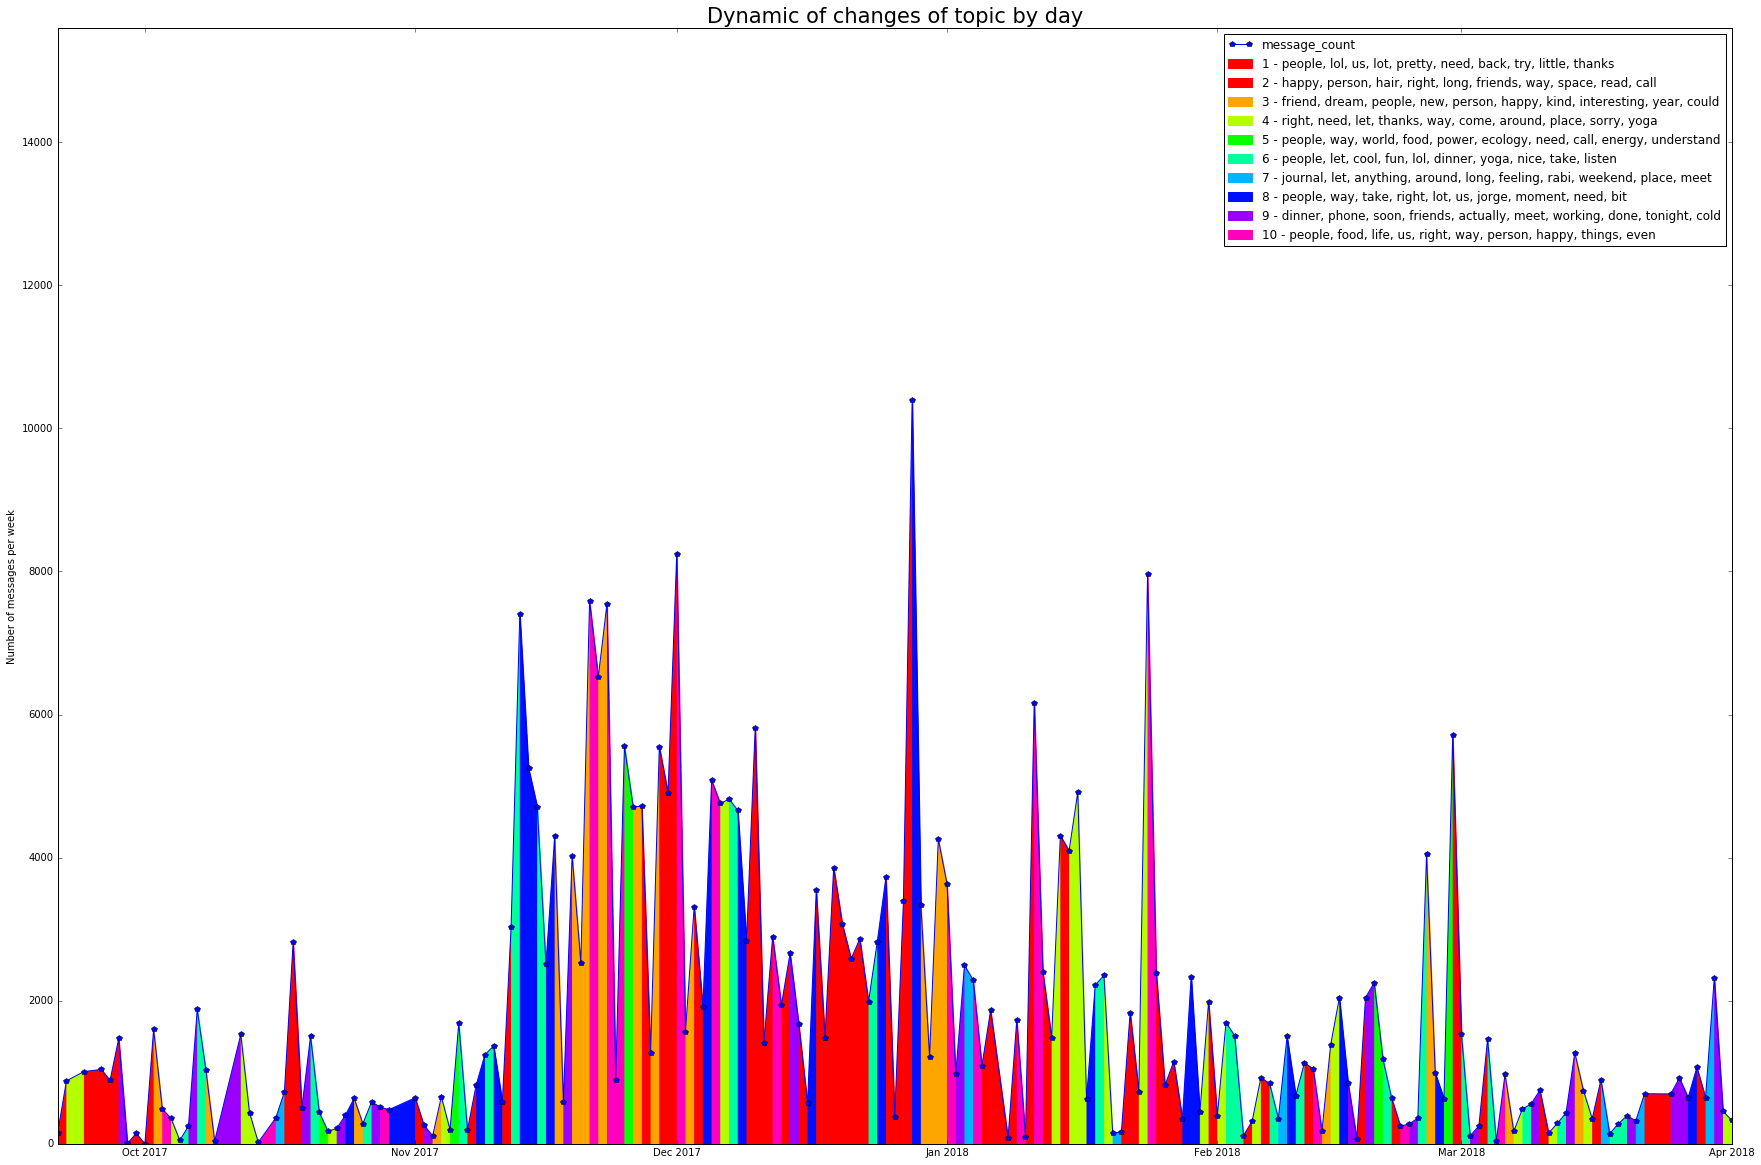

In [53]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,20))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_day_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Number of messages per week')
plt.title('Dynamic of changes of topics by day', fontsize=21)
plt.savefig('joshua_day_dynamic_norm_2.png')
plt.show()

In [54]:

week_text = corpus.groupby(corpus.mes_date.apply(lambda x: '{1}-{0}'.format(x.week, x.year))).agg(lambda x: ' '.join(x))['text']
print(week_text.shape)
week_text.head()

(28,)


mes_date
2017-38      cool good night thanks talking great good ni...
2017-39     going  alright sleepy 3 pretty relaxing weeke...
2017-40    going  going good  good spent weekend visiting...
2017-41    wow beautiful  hope good day good night hope c...
2017-42    yes going dear back knows long necessary could...
Name: text, dtype: object

In [55]:
morph = pymorphy2.MorphAnalyzer()
%time week_text_norm = week_text.apply(lambda x: normalise_string(x))
week_text_norm.head()

CPU times: user 2.4 s, sys: 12.7 ms, total: 2.42 s
Wall time: 2.44 s


mes_date
2017-38    cool good night thanks talking great good nigh...
2017-39    going alright sleepy pretty relaxing weekend w...
2017-40    going going good good spent weekend visiting c...
2017-41    wow beautiful hope good day good night hope co...
2017-42    yes going dear back knows long necessary could...
Name: text, dtype: object

In [56]:

counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.1, max_df=0.5)

Words in the library: 1721

Words that are not applicable to the threshold:  [('good', 948), ('really', 546), ('think', 537), ('going', 468), ('yes', 449), ('feel', 430), ('know', 425), ('time', 423), ('want', 412), ('also', 400), ('love', 379), ('work', 353), ('sleep', 319), ('people', 310), ('night', 304), ('talk', 301), ('day', 283), ('ok', 280), ('okay', 269), ('get', 264)] 

Words with the higher threshold: ['moment', 'relationship', 'family', 'video', 'diana', 'years', 'hair', 'agree', 'photos', 'everyone', 'white', 'comfortable', 'crazy', 'anyway', 'article', 'sleeping', 'japanese', 'cold', 'appreciate', 'end', 'rest', 'self', 'trump', 'enough', 'thoughts', 'skiing', 'american', 'painful', 'expectations', 'move', 'dreams', 'excited', 'ago', 'ben', 'girl', 'name', 'podcast', 'chinese', 'costa', 'rabi']

Words with the lower threshold:  ['20th', 'memorable', 'mhmmm', 'minded', 'misunderstanding', 'cartoon', 'nation', 'massages', 'nationalism', 'canada', 'objective', 'occurred', 'o

In [62]:
lda_week_norm, gamma_week_norm = get_lda_model(counts, corpus_id2word)


ELBO = -186641.0998, time: 5 seconds


In [58]:
build_topic_words_report(lda_week_norm, top_words_num=15)


0 topic: photos, video, diana, sleeping, costa, scuba, relationship, rica, cold, moment, family, expectations, dreams, appreciate, agree
1 topic: relationship, crazy, moment, japanese, diana, family, comfortable, podcast, years, enough, cold, hair, wrong, works, self
2 topic: hair, money, massage, china, rabi, diana, name, sleeping, telegram, cream, ice, painful, leaving, moment, older
3 topic: skiing, move, podcast, colleague, sick, moving, relationship, welcome, cold, chinese, depression, expectations, fine, works, stay
4 topic: family, dad, date, cousin, conversation, pie, bring, humanity, song, visit, hurt, happen, expect, gym, trump
5 topic: article, white, vr, gun, name, reality, project, study, enjoyed, stupid, create, skiing, de, trump, human
6 topic: painful, years, white, japanese, chinese, culture, everyone, crazy, moment, american, kim, asian, happened, weight, problem
7 topic: article, agree, giving, give, anyway, march, ben, healthy, feelings, move, fish, shall, self, lov

In [59]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-38,cool good night thanks talking great good nigh...,0,2048,2017-09-18
2017-39,going alright sleepy pretty relaxing weekend w...,3,3554,2017-09-25
2017-40,going going good good spent weekend visiting c...,0,5654,2017-10-02
2017-41,wow beautiful hope good day good night hope co...,4,2029,2017-10-09
2017-42,yes going dear back knows long necessary could...,3,6521,2017-10-16


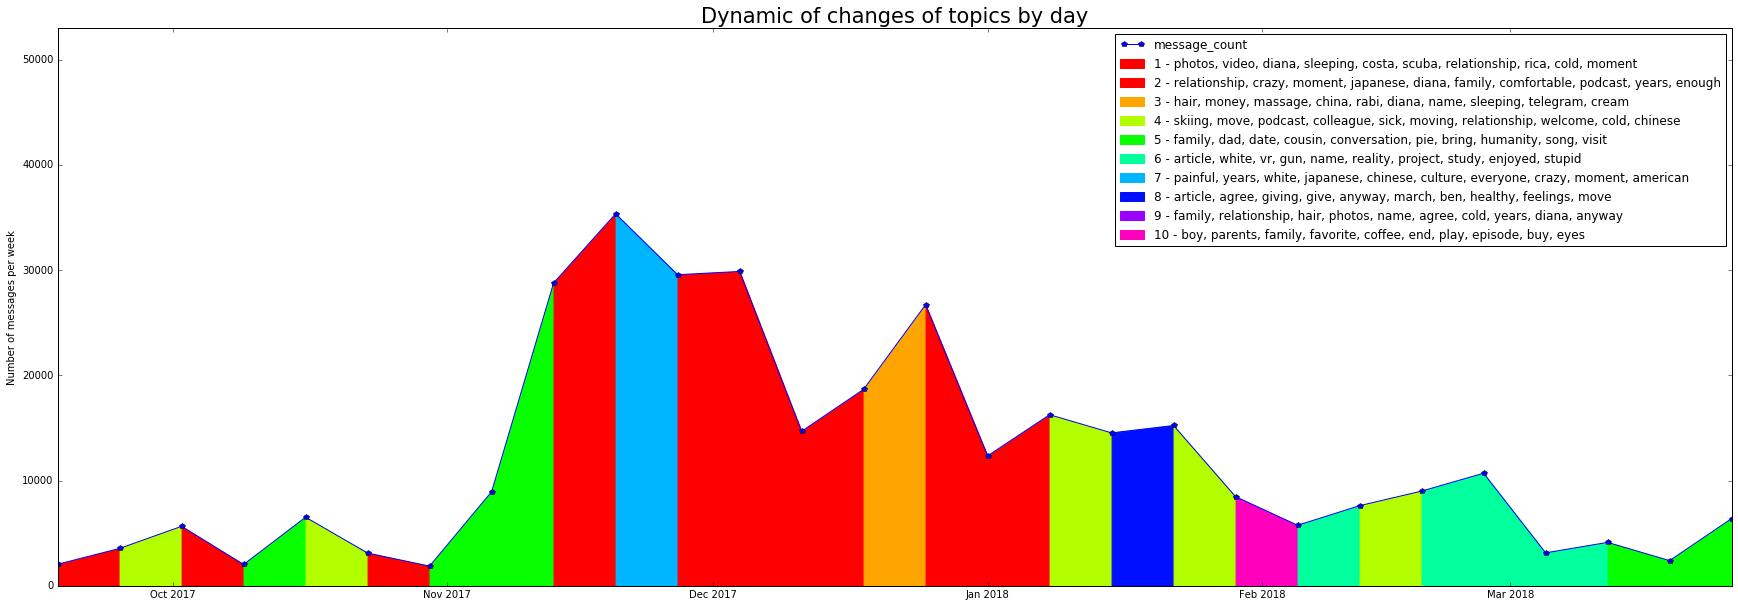

In [60]:

import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Number of messages per week')
plt.title('Dynamic of changes of topics by day', fontsize=21)
plt.savefig('joshua_week.png')
plt.show()

Last step: Same model in normalized form. 

In [61]:
counts, vectorizer, corpus_id2word = get_words_by_threshold_report(week_text_norm, min_df=0.1, max_df=0.75)


Words in the library: 1889

Words that are not applicable to the threshold:  [('good', 948), ('really', 546), ('think', 537), ('going', 468), ('yes', 449), ('feel', 430), ('know', 425), ('time', 423), ('want', 412), ('also', 400), ('love', 379), ('work', 353), ('sleep', 319), ('people', 310), ('night', 304), ('talk', 301), ('day', 283), ('ok', 280), ('okay', 269), ('get', 264)] 

Words with the higher threshold: ['person', 'could', 'even', 'life', 'read', 'yoga', 'different', 'makes', 'movie', 'feeling', 'look', 'phone', 'together', 'tell', 'better', 'food', 'mean', 'guess', 'told', 'beautiful', 'year', 'best', 'though', 'everything', 'watch', 'dream', 'bad', 'many', 'always', 'mom', 'trying', 'remember', 'seattle', 'hear', 'book', 'tonight', 'making', 'world', 'working', 'hard']

Words with the lower threshold:  ['20th', 'mass', 'massages', 'memorable', 'mhmmm', 'butter', 'minded', 'canada', 'misunderstanding', 'nationalism', 'objective', 'occurred', 'brings', 'ohhhh', 'breaks', 'nati

In [45]:
lda_day_norm, gamma_day_norm = get_lda_model(counts, corpus_id2word)


ELBO = -327508.9610, time: 19 seconds


In [63]:
build_topic_words_report(lda_week_norm, top_words_num=15)


0 topic: year, tell, person, makes, told, moment, could, read, beautiful, different, family, even, look, better, remember
1 topic: yoga, book, watch, cold, hear, music, start, study, better, read, heard, wait, another, yea, class
2 topic: yoga, boy, parents, eat, class, hang, food, book, could, feeling, family, working, skiing, dream, listen
3 topic: feeling, food, makes, phone, person, movie, could, better, together, watch, diana, another, mom, miss, used
4 topic: person, bad, movie, even, life, together, could, always, japanese, guess, different, look, chinese, read, feels
5 topic: tonight, life, even, movie, food, article, read, person, best, mind, could, watch, tell, hang, help
6 topic: person, could, feeling, together, expectations, look, small, even, making, makes, photos, space, building, different, mean
7 topic: different, hard, weekend, movie, chat, name, hang, reality, app, book, life, space, working, anything, sense
8 topic: energy, mind, sense, point, expect, valuable, coul

In [64]:
def weekpair_2date(pair):
    atime = time.strptime('{} {} 1'.format(*pair.split('-')), '%Y %W %w')
    return pd.to_datetime('{0}-{1}-{2}'.format(atime.tm_year, atime.tm_mon, atime.tm_mday))

topic_dynamic = pd.DataFrame(week_text_norm)
topic_dynamic['topic'] = np.argmax(gamma_week_norm, axis=1)
topic_dynamic['message_count'] = week_text.apply(len)
topic_dynamic['date'] = list(map(weekpair_2date, topic_dynamic.index))
topic_dynamic.sort_values('date', inplace=True)
topic_dynamic.head()

,text,topic,message_count,date
mes_date,,,,
2017-38,cool good night thanks talking great good nigh...,4,2048,2017-09-18
2017-39,going alright sleepy pretty relaxing weekend w...,1,3554,2017-09-25
2017-40,going going good good spent weekend visiting c...,4,5654,2017-10-02
2017-41,wow beautiful hope good day good night hope co...,8,2029,2017-10-09
2017-42,yes going dear back knows long necessary could...,7,6521,2017-10-16


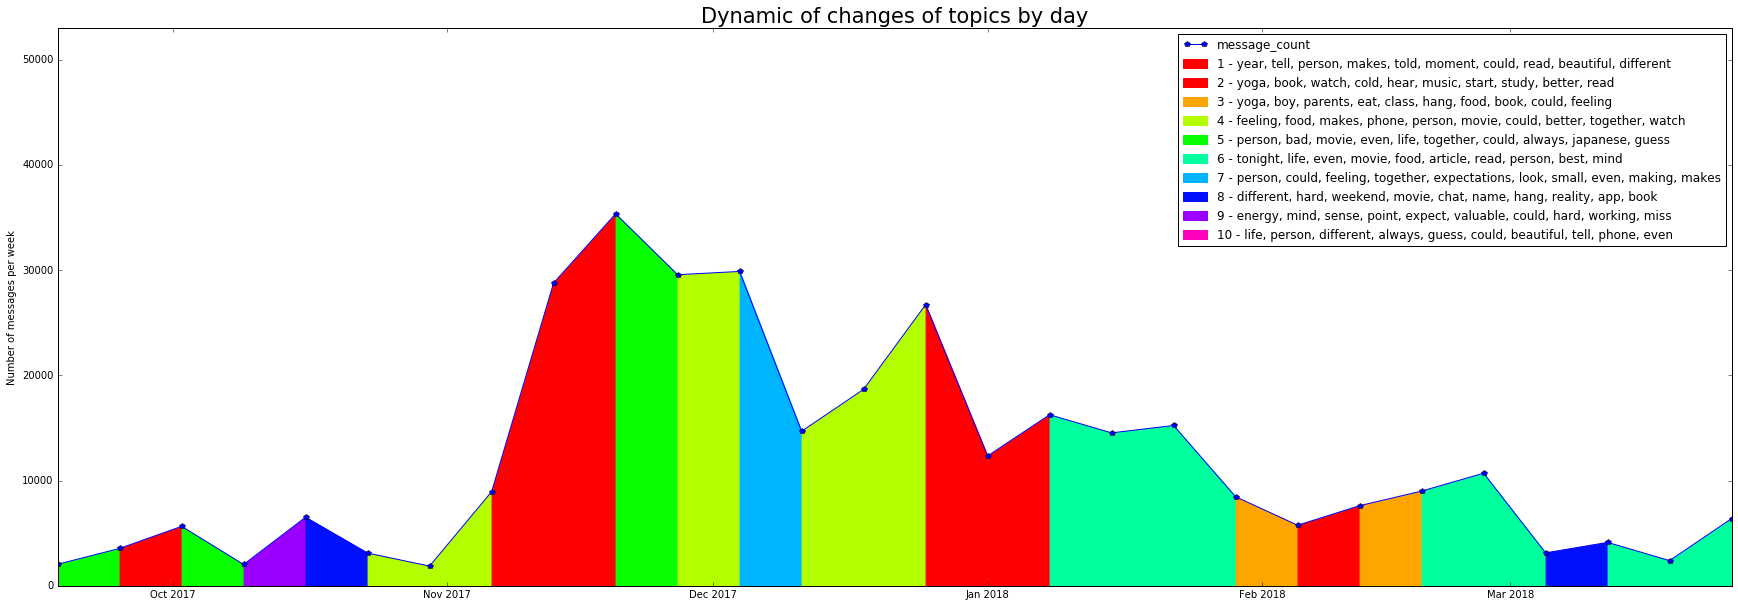

In [65]:
import matplotlib as mpl
cmap = mpl.cm.hsv
normalize = mpl.colors.Normalize(vmin=1, vmax=10)

plt.figure(figsize=(30,10))
plt.plot(topic_dynamic.date, topic_dynamic.message_count, '-p')

for topic_index in range(10):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[:1], 
        x=topic_dynamic.date.values[:1], 
        color=cmap(normalize(topic_index)),
        label = '{0} - {1}'.format(topic_index + 1, ', '.join(list(zip(*lda_week_norm.show_topic(topic_index, topn=10)))[0]))
    )
for step in range(topic_dynamic.shape[0]):
    plt.fill_between(
        y1=0, y2=topic_dynamic.message_count[step: step+2], 
        x=topic_dynamic.date.values[step: step+2], 
        color=cmap(normalize(topic_dynamic.topic.iloc[step])),
    )
    
plt.legend(fontsize=12)
plt.ylim([0, topic_dynamic.message_count.max() * 1.5])
plt.ylabel('Number of messages per week')
plt.title('Dynamic of changes of topics by day', fontsize=21)
plt.savefig('joshua_week_2.png')
plt.show()